In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import transforms as pth_transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt

from helpers import power_method, prep_for_power_method

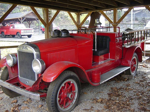

In [3]:
img_file = 'assets/n03345487_fire_engine.JPEG'
img = Image.open(img_file).convert('RGB')
W, H = img.size
display(img.resize((150,150*H//W)))

# DINO demo

In [4]:
import dino

In [5]:
image_size = 480
transform = pth_transforms.Compose([
        pth_transforms.Resize(int(image_size*256/224)),
        pth_transforms.CenterCrop(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_t = transform(img)

In [ ]:
# Load model
device = "cuda:0"
arch = 'vit_small'
patch_size = 8
model = dino.__dict__[arch](patch_size=patch_size)
model.eval()
model = model.to(device)
dino.load_pretrained_vit_weights(model, arch, patch_size=patch_size)
model = dino.replace_attn(model)

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [7]:
# Extract attention
model_with_hooks = dino.ManipulateAttention(model, just_save=True)

with torch.no_grad():
    o = model.forward(img_t.to(device).unsqueeze(0))

model_with_hooks.remove_hooks()
attentions = torch.stack(model_with_hooks.attentions) # (n_layers, b, h, seq, seq)
print(attentions.shape)
attentions = attentions.cpu()

torch.Size([12, 1, 6, 3601, 3601])


In [8]:
# Power iteration
L = 8
H = 1
attention = attentions[L,0,H]
my_att = torch.softmax(attention[...,1:,1:], dim=-1)
N=int(my_att.shape[-1]**0.5)
init_state = torch.zeros(my_att.shape[-1]); init_state[N**2//2+N//2] = 1.0
T = prep_for_power_method(my_att)
att_bounced_p, intermeds = power_method(T, init_state, max_iter=30, return_intermed=True)
print(f"Performed {len(intermeds)} iterations of power method")

Performed 16 iterations of power method


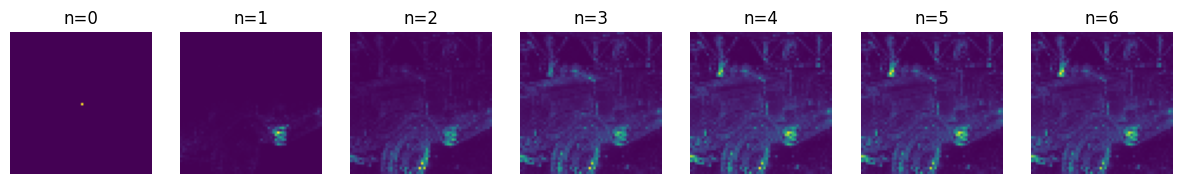

In [9]:
# Visualization
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1,7, i+1)
    plt.imshow(intermeds[i].reshape(N,N)); plt.axis('off')
    plt.title(f"n={i}")

# DINOv2 demo

Requires DINOv2 repository. For this run
```
git clone https://github.com/facebookresearch/dinov2.git ..dinov2
```

In [10]:
import dino_v2

/CT/steady_state/work/code_olaf/attention_chains_code/../dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/CT/steady_state/work/code_olaf/attention_chains_code/../dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/CT/steady_state/work/code_olaf/attention_chains_code/../dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [ ]:
# Load model
device = "cuda:0"
arch = 'vit_small'
model = dino_v2.load_pretrained(arch)
model.eval()
model = model.to(device)
model = dino_v2.replace_attn(model)

Using cache found in ./models/dinov2/facebookresearch_dinov2_main


Loading DINOv2 model with backbone: dinov2_vits14_reg


In [12]:
image_size = 700
transform = pth_transforms.Compose([
        pth_transforms.Resize(int(image_size*256/224)),
        pth_transforms.CenterCrop(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_t = transform(img)

In [13]:
# Extract attention
model_with_hooks = dino_v2.ManipulateAttention(model, just_save=True)
with torch.no_grad():
    o = model.forward(img_t.to(device).unsqueeze(0))

model_with_hooks.remove_hooks()
attentions = torch.stack(model_with_hooks.attentions).cpu() # (n_layers, b, h, seq, seq)
print(attentions.shape)


torch.Size([12, 1, 6, 2505, 2505])


In [14]:
# Power iteration
L = 8
H = 1
attention = attentions[L,0,H]
my_att = torch.softmax(attention[...,1:,1:], dim=-1) # Skip [CLS] token
N=int(my_att.shape[-1]**0.5)
init_state = torch.zeros(my_att.shape[-1]); init_state[N**2//2+N//2] = 1.0
T = prep_for_power_method(my_att)
att_bounced_p, intermeds = power_method(T, init_state, max_iter=30, return_intermed=True)
print(f"Performed {len(intermeds)} iterations of power method")
intermeds = intermeds[:,model.num_register_tokens:]

Performed 30 iterations of power method


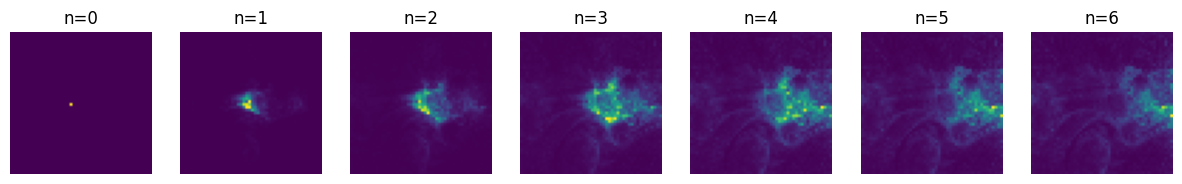

In [15]:
# Visualization
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1,7, i+1)
    plt.imshow(intermeds[i].reshape(N,N)); plt.axis('off')
    plt.title(f"n={i}")